In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import ast
import statsmodels.api as sm
import requests
from bs4 import BeautifulSoup
import matplotlib.ticker as ticker

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../2_clean_data/final_combine_data.csv')

In [13]:
#dependent variables: average_gpa, average_rating
#independent variables: years_taught, salary

In [3]:
#Columns with lists are represented as strings, so this is converting them into list/np.array types

for index, row in df.iterrows():
    df.iloc[index]['salaries'] = ast.literal_eval(df.iloc[index]['salaries'])
    df.iloc[index]['semester'] = ast.literal_eval(df.iloc[index]['semester'])
    df.iloc[index]['years_taught'] = ast.literal_eval(df.iloc[index]['years_taught'])
    df.iloc[index]['course'] = ast.literal_eval(df.iloc[index]['course'])
    df.iloc[index]['average_rating'] = np.fromstring(df.iloc[index]['average_rating'].strip("[]"), sep=',')
    df.iloc[index]['num_reviews'] = np.fromstring(df.iloc[index]['num_reviews'].strip("[]"), sep=',')
    df.iloc[index]['average_gpa'] = np.fromstring(df.iloc[index]['average_gpa'].strip("[]"), sep=',')
    df.iloc[index]['num_students'] = ast.literal_eval(df.iloc[index]['num_students'])
    


#json.loads(df.iloc[0]['salaries'])[0]

In [6]:
#Find rows where lists containing planetterp data aren't all the same length

count = 0
for index, row in df.iterrows():
    if all(len(x) == len(row['course']) for x in [row['semester'], row['average_rating'], row['num_reviews'], row['average_gpa'], row['num_students']]):
        pass
    else:
        display(df.iloc[index])

name                                                       MIN WANG
course            [EDHD320, EDHD425, EDHD425, EDHD425, EDHD320, ...
semester          [spring 2021, spring 2010, fall 2012, winter 2...
average_rating    [5.0, 3.0, 3.0, 2.0, nan, nan, nan, nan, nan, ...
num_reviews       [1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan, ...
average_gpa       [3.51, nan, 3.23, nan, 3.55, 4.0, 3.29, 3.77, ...
num_students      [82, 0, 68, 0, 37, 33, 39, 37, 38, 6, 21, 50, ...
years_taught      [2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...
salaries          [77524.08, 88736.8, 103327.84, 103327.84, 1057...
departments       ['EDUC', 'EDUC', 'EDUC', 'EDUC', 'EDUC', 'EDUC...
real_name(s)                                              Wang, Min
_merge                                                         both
Name: 1615, dtype: object

name                                                    MIN QI WANG
course            [HLTH652, HLTH652, HLTH652, HLTH652, HLTH652, ...
semester          [fall 2020, fall 2022, fall 2014, spring 2016,...
average_rating        [nan, nan, nan, nan, nan, nan, nan, nan, nan]
num_reviews           [nan, nan, nan, nan, nan, nan, nan, nan, nan]
average_gpa       [3.81, 3.55, 3.68, 3.85, 3.81, 3.6, 4.0, 3.89,...
num_students                         [8, 10, 6, 8, 10, 8, 5, 8, 15]
years_taught      [2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...
salaries          [102630.38, 106709.29, 110883.47, 110883.47, 1...
departments       ['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...
real_name(s)                                           Wang, Min Qi
_merge                                                         both
Name: 1616, dtype: object

In [5]:
#Drop rows 1615 and 1615 (for now) to allow for exploding

df = df.drop([1615, 1616], axis=0)

In [7]:
df = df.explode(['course', 'semester', 'average_rating', 'num_reviews', 'average_gpa', 'num_students'])

In [8]:
df[['sem', 'year']] = df['semester'].str.split(' ', 1, expand=True)

/tmp/ipykernel_130/2949145723.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['sem', 'year']] = df['semester'].str.split(' ', 1, expand=True)


In [10]:
df.head()

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,years_taught,salaries,departments,real_name(s),_merge,sem,year
0,A SHARMA,ASTR300,fall 2019,1.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,fall,2019
0,A SHARMA,ASTR300,spring 2019,1.5,2.0,2.85,57,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,spring,2019
0,A SHARMA,ASTR300,fall 2020,2.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,fall,2020
0,A SHARMA,ASTR300,winter 2021,3.0,1.0,NaN,0,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,winter,2021
0,A SHARMA,ASTR300,fall 2016,NaN,NaN,2.92,51,"[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[68417.04, 146412.46, 76537.12, 76537.12, 7768...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...","Sharma, A Surjalal",both,fall,2016


In [9]:
df['year'] = df['year'].astype('int')

In [10]:
#Number of observations where professors have salaries for semesters they have actually taught
#Difference might become smaller if we are able to match names that have changed over time

print(len(df))
print(len(df[df.apply(lambda x: x['year'] in x['years_taught'], axis=1)]))

52082
42839


In [11]:
#Drop rows where professors don't have salaries for semesters they actually have taught

df = df[df.apply(lambda x: x['year'] in x['years_taught'], axis=1)]

In [12]:
df['teaching_duration'] = df['years_taught'].apply(lambda x: max(x) - min(x))

In [13]:
#Add column that shows how long professors have been teaching as of the year of the course
df['teaching_duration_as_of_course'] = None
for index, row in df.iterrows():
    df.loc[index, 'teaching_duration_as_of_course'] = row['year'] - min(row['years_taught']) 

In [14]:
#Create a salary column which stores the salary a professor earned while they taught a certain course
#MIGHT NEED TO CHANGE BC NOT SURE IF START OF YEAR IS Aug (ACADEMIC YEAR BEG) OR Jan (CALENDAR YEAR BEG)

df['salary'] = None

for index, row in df.iterrows():
    df.loc[index,'salary'] = row['salaries'][row['years_taught'].index(row['year'])]
    
df['salary'] = df['salary'].astype('int')

In [182]:
df['teaching_duration_as_of_course'] = df['teaching_duration_as_of_course'].astype('int')
df['teaching_duration'] = df['teaching_duration'].astype('int')

In [15]:
#Reset index

df.reset_index(drop=True, inplace=True)

In [269]:
#Unique departments (first 4 letters of course)

uniqueCourses = df['course'].str[0:4].unique()

print(df['course'].str[0:4].unique())
print(len(df['course'].str[0:4].unique()))

['PSYC' 'ASTR' 'CMSC' 'ECON' 'HESI' 'EDHI' 'COMM' 'INST' 'ENAE' 'ENME'
 'ENRE' 'ARTH' 'PHYS' 'STAT' 'PHSC' 'ENGL' 'ANTH' 'BIOE' 'GEMS' 'MATH'
 'BMGT' 'BULM' 'CMLT' 'JWST' 'ISRL' 'BUSO' 'DANC' 'ARHU' 'TDPS' 'UNIV'
 'ENEE' 'PERS' 'ARAB' 'ENCE' 'HIST' 'HACS' 'CCJS' 'FIRE' 'GEOL' 'SOCY'
 'CPSD' 'CPSP' 'AASP' 'HNUH' 'PLCY' 'WMST' 'BUFN' 'ENTS' 'MSML' 'HONR'
 'PUAF' 'JOUR' 'LING' 'PHIL' 'BSCI' 'BIOL' 'AOSC' 'HDCC' 'LGBT' 'TLTC'
 'EDHD' 'EDUC' 'EDMS' 'CHEM' 'CPMS' 'ENES' 'HESP' 'HEBR' 'GEOG' 'LARC'
 'EDCP' 'IDEA' 'FMSC' 'NEUR' 'MIEH' 'BUMK' 'ENST' 'ANSC' 'INAG' 'CHBE'
 'ENCH' 'SPAN' 'SLLC' 'ENTM' 'BUSI' 'BUSM' 'FREN' 'AMST' 'KNES' 'MLSC'
 'THET' 'CHIN' 'EALL' 'BUMO' 'TLPL' 'EDCI' 'ENPM' 'AREC' 'BISI' 'CBMG'
 'ENSP' 'GVPT' 'PHPE' 'ENMA' 'HLTH' 'BSOS' 'SPHL' 'BUDT' 'CHSE' 'CPSF'
 'LBSC' 'AAST' 'BCHM' 'EPIB' 'ARTT' 'BUAC' 'HLSC' 'CLFS' 'SMLP' 'HLMN'
 'MLAW' 'SURV' 'PLSC' 'EDPS' 'AGNR' 'EDSP' 'ENFP' 'INFM' 'UMEI' 'BEES'
 'AMSC' 'CLAS' 'LATN' 'IMMR' 'HHUM' 'BIOM' 'URSP' 'CHPH' 'CPBE' 'NACS'
 'MUSC

In [132]:
df_codes = pd.read_csv('../2_clean_data/code_departments.csv')

In [133]:
df['department'] = [df_codes[df_codes['Major'].str.contains(row['course'][0:4])]['Department'].values[0] for index, row in df.iterrows()]

In [134]:
df['department'].unique()

array(['CMNS', 'BSOS', 'EDUC', 'ARHU', 'INFO', 'ENGR', 'SPHL', 'OUGS',
       'BMGT', 'SPP', 'JOUR', 'AGNR', 'ARCH'], dtype=object)

In [18]:
df['teaching_duration'] = df['years_taught'].apply(lambda x: max(x) - min(x))

In [135]:
#Rearrange columns to be more intuitive

df = df[["name", "course", "department", "sem", "year", "average_rating", "num_reviews", "average_gpa", "num_students", "real_name(s)", "years_taught", "teaching_duration", "teaching_duration_as_of_course", "salaries", "salary", "departments", "_merge", "semester"]]


In [169]:
#All average_gpa values that are NaN have zero students for that course

display(df[df['average_gpa'].isna()].sort_values(by='num_reviews', ascending=False))
print(df[df['average_gpa'].isna()]['num_students'].unique())

,name,course,department,sem,year,average_rating,num_reviews,average_gpa,num_students,real_name(s),years_taught,teaching_duration,teaching_duration_as_of_course,salaries,salary,departments,_merge,semester
26614,MICHAEL GALCZYNSKI,ENES100,ENGR,summer,2022,5.0,14.0,NaN,0,"Galczynski, Michael Christopher","[2016, 2017, 2018, 2019, 2020, 2021, 2022]",6,1,"[65000.0, 67145.0, 67145.0, 68487.9, 71604.2, ...",67145,"['ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR...",both,summer 2022
26241,MESTIYAGE GUNATILLEKA,STAT401,CMNS,fall,2022,4.818182,11.0,NaN,0,"Gunatilleka, Mestiyage Don Danul Kavindr | Gun...","[2020, 2021, 2022]",2,1,"[43486.56, 44356.29, 73502.75]",44356,"['CMNS', 'CMNS', 'CMNS']",both,fall 2022
7031,DANIEL GOTTESMAN,CMSC456,CMNS,fall,2022,1.7,10.0,NaN,0,"Gottesman, Daniel Eric",[2022],0,0,[282800.0],282800,['CMNS'],both,fall 2022
22609,LENEA STOCKER,CHEM135,CMNS,winter,2021,2.857143,7.0,NaN,0,"Stocker, Lenea Hope","[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",8,5,"[56650.0, 60093.3, 60093.3, 61445.3, 61445.3, ...",62674,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,winter 2021
26622,MICHAEL GALCZYNSKI,ENES102,ENGR,summer,2021,5.0,7.0,NaN,0,"Galczynski, Michael Christopher","[2016, 2017, 2018, 2019, 2020, 2021, 2022]",6,1,"[65000.0, 67145.0, 67145.0, 68487.9, 71604.2, ...",67145,"['ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR...",both,summer 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14672,JAMES GREEN,ENES460,ENGR,winter,2021,3.0,1.0,NaN,0,"Green, James Vaughn","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,9,"[135660.0, 156009.22, 159129.4, 159129.4, 1608...",185803,"['ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR...",both,winter 2021
14676,JAMES GREEN,ENES464,ENGR,spring,2015,1.0,1.0,NaN,0,"Green, James Vaughn","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,9,"[135660.0, 156009.22, 159129.4, 159129.4, 1608...",185803,"['ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR...",both,spring 2015
14775,JAMES HANSON,MATH445,CMNS,winter,2022,2.0,1.0,NaN,0,"Hanson, James C.","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,9,"[131338.74, 168239.17, 184749.69, 212462.0, 21...",262727,"['AGNR', 'AGNR', 'AGNR', 'AGNR', 'AGNR', 'AGNR...",both,winter 2022
14780,JAMES MACDONALD,AREC433,AGNR,summer,2021,5.0,1.0,NaN,0,"MacDonald, James","[2020, 2021, 2022]",2,2,"[165000.0, 168300.0, 174338.65]",174338,"['AGNR', 'AGNR', 'AGNR']",both,summer 2021


[0]


In [167]:
df[df['average_gpa'].isna()]['num_reviews'].max()

14.0

In [186]:
#Drop rows where there aren't any students for that course (might want to move reviews over to another semester)

df_test = df[df['average_gpa'].notna()].copy()
df_test['average_gpa'] = df_test['average_gpa'].astype('float')

In [122]:
df['department'].unique()

array(['CMNS', 'BSOS', 'EDUC', 'ARHU', 'INFO', 'ENGR', 'SPHL',
       'Office of Undergraduate Studies', 'BMGT',
       'School of Public Policy', 'JOUR', 'AGNR', 'ARCH'], dtype=object)

In [411]:
df_zero = df[(df['teaching_duration_as_of_course'] == 0) & (df['average_gpa'].notna())]
df_zero.groupby('name')['course'].nunique()

name
A KRUGLANSKI      1
A.U. SHANKAR      3
AARON FINKLE      4
AARON HOOD        1
AARON SWANLEK     1
                 ..
ZHONGCHI LIU      1
ZITA NUNES        2
ZOHREH DAVOUDI    1
ZSUZSA DACZO      2
ZUBIN JELVEH      2
Name: course, Length: 2197, dtype: int64

In [420]:
df_zero = df.copy()
df_zero.groupby('department').sum()

/tmp/ipykernel_1057/2882834126.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_zero.groupby('department').sum()


,year,teaching_duration,salary
department,,,
Agriculture,2627488,9681,142813758
Architecture,532878,1404,17227668
Arts/Humanities,21794995,78945,751755626
BSOS,10228807,36927,529159705
Business,8331964,30116,582898826
CMNS,17258137,63591,1052460547
Education,2538866,8458,105060110
Engineering,10548801,41602,754244110
Information Studies,1557024,4498,65848027


In [442]:
df[(df['teaching_duration_as_of_course'] == 0) & (df['average_gpa'].notna())].head()


,name,course,department,sem,year,average_rating,num_reviews,average_gpa,num_students,real_name(s),years_taught,teaching_duration,teaching_duration_as_of_course,salaries,salary,departments,_merge,semester
1,A KRUGLANSKI,PSYC489H,BSOS,spring,2015,NaN,NaN,3.55,8,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]",7,0,"[289244.91, 289244.91, 296487.96, 296487.96, 3...",302417,"['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring 2015
26,A.U. SHANKAR,CMSC412,CMNS,fall,2013,NaN,NaN,2.28,27,"Shankar, A.U.","[2013, 2014, 2015, 2016, 2017, 2018, 2019]",6,0,"[118132.88, 122857.87, 126568.18, 63284.09, 12...",129609,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,fall 2013
30,A.U. SHANKAR,CMSC414,CMNS,spring,2013,NaN,NaN,2.72,47,"Shankar, A.U.","[2013, 2014, 2015, 2016, 2017, 2018, 2019]",6,0,"[118132.88, 122857.87, 126568.18, 63284.09, 12...",129609,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,spring 2013
33,A.U. SHANKAR,CMSC712,CMNS,spring,2013,NaN,NaN,3.67,4,"Shankar, A.U.","[2013, 2014, 2015, 2016, 2017, 2018, 2019]",6,0,"[118132.88, 122857.87, 126568.18, 63284.09, 12...",129609,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,spring 2013
43,AARON FINKLE,ECON306,BSOS,fall,2017,NaN,NaN,2.69,64,"Finkle, Aaron","[2017, 2018, 2019, 2020, 2021, 2022]",5,0,"[69000.0, 69000.0, 70380.0, 73582.4, 75054.05,...",77699,"['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS']",both,fall 2017


In [438]:
df_years_taught = df[(df['teaching_duration_as_of_course'] == 0) & (df['average_gpa'].notna())]
print(df_years_taught.groupby('name')['average_gpa'].nunique())

name
A KRUGLANSKI      1
A.U. SHANKAR      3
AARON FINKLE      5
AARON HOOD        1
AARON SWANLEK     2
                 ..
ZHONGCHI LIU      1
ZITA NUNES        2
ZOHREH DAVOUDI    1
ZSUZSA DACZO      4
ZUBIN JELVEH      3
Name: average_gpa, Length: 2197, dtype: int64


In [79]:
df['num_reviews']

0        1.0
1        2.0
2        1.0
3        1.0
4        NaN
        ... 
42834    NaN
42835    NaN
42836    NaN
42837    NaN
42838    NaN
Name: num_reviews, Length: 42839, dtype: object

In [68]:
print(len(df['num_reviews']))
print(df['num_reviews'].notna().sum())

42839
7190


In [35]:
df[df['department'] == 'CMNS']['course'].nunique()

986

In [37]:
#Number of reviews written in each department
#CMNS, ARHU, BSOS have most reviews


display(df.groupby('department')['num_reviews'].sum().sort_values(ascending=False))

department
CMNS                               4758.0
ARHU                               1570.0
BSOS                               1177.0
ENGR                               1149.0
BMGT                                806.0
Office of Undergraduate Studies     483.0
EDUC                                246.0
INFO                                220.0
AGNR                                185.0
SPHL                                159.0
JOUR                                 95.0
School of Public Policy              66.0
ARCH                                 35.0
Name: num_reviews, dtype: object

In [85]:
df.head()

,name,course,department,sem,year,average_rating,num_reviews,average_gpa,num_students,real_name(s),years_taught,teaching_duration,teaching_duration_as_of_course,salaries,salary,departments,_merge,semester
0,A SHARMA,ASTR300,CMNS,fall,2019,1.0,1.0,NaN,0,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,fall 2019
1,A SHARMA,ASTR300,CMNS,spring,2019,1.5,2.0,2.85,57,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,spring 2019
2,A SHARMA,ASTR300,CMNS,fall,2020,2.0,1.0,NaN,0,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,fall 2020
3,A SHARMA,ASTR300,CMNS,winter,2021,3.0,1.0,NaN,0,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,winter 2021
4,A SHARMA,ASTR300,CMNS,fall,2016,NaN,NaN,2.92,51,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,fall 2016


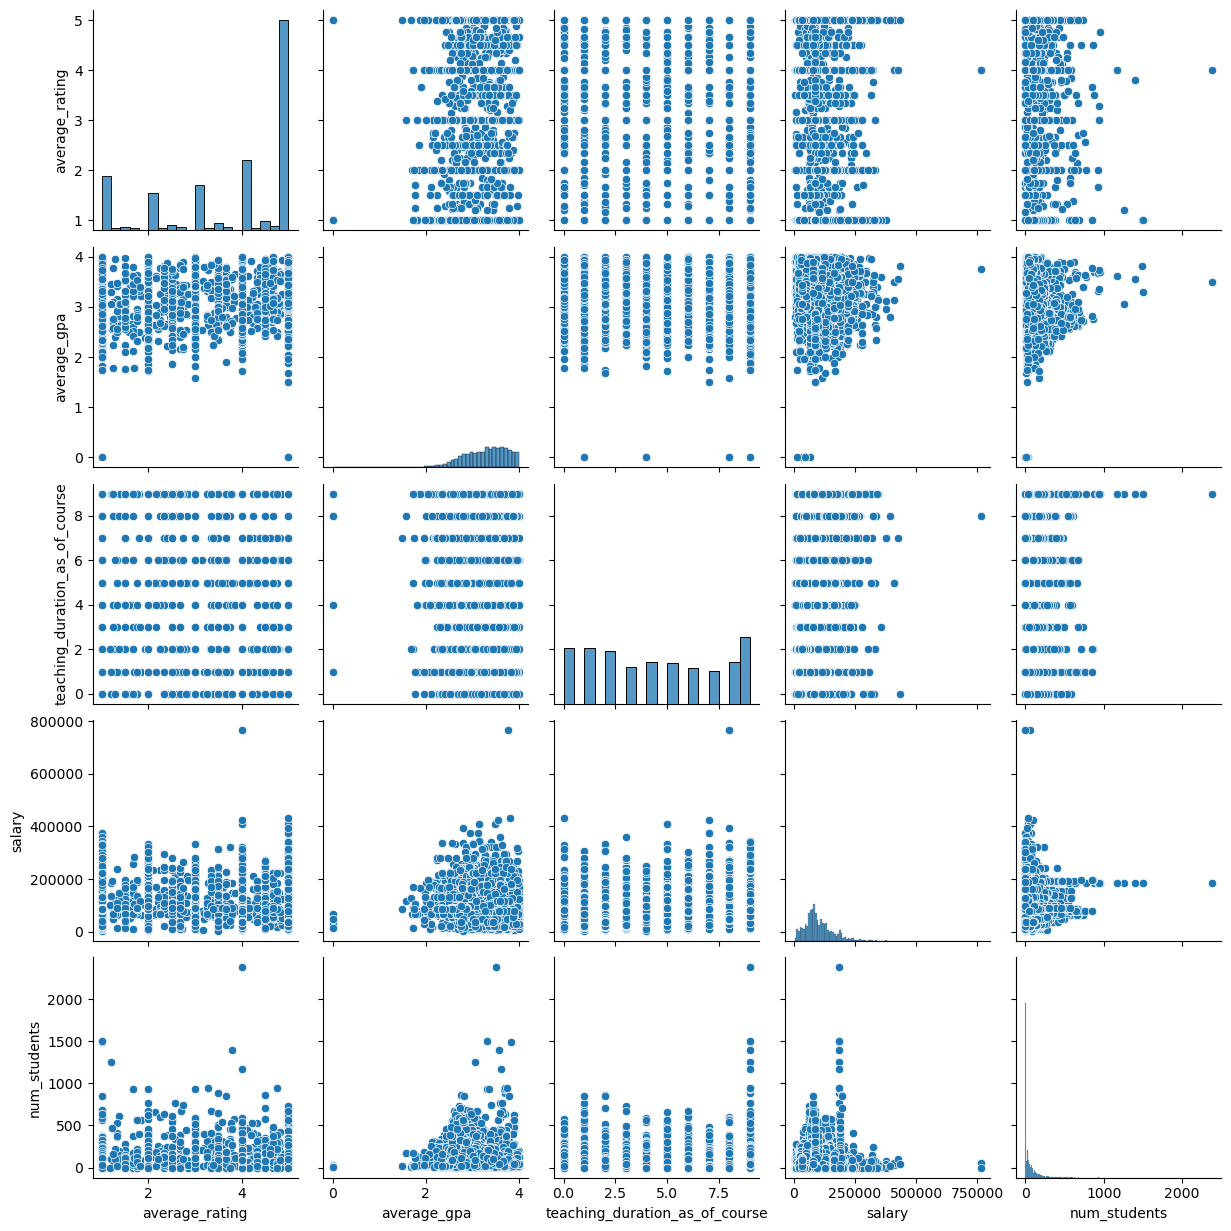

In [189]:
#Broad pairplot between our 2 independent and 2 dependent variables

df_test = df[(df['num_reviews'] >= 0)]

sns.pairplot(df_test[["average_rating", "average_gpa", "teaching_duration_as_of_course", "salary", "num_students"]])

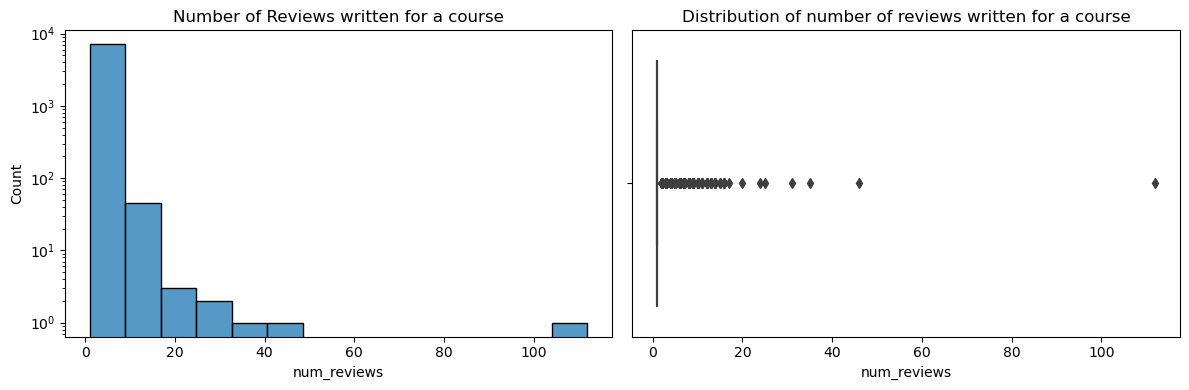

In [21]:
#Histogram distribution for number of reviews written for a course (logarithmic on y axis)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4))

g = sns.histplot(data = df, x = 'num_reviews', ax = axes[0])
g.set_yscale('log')
g.set_title("Number of Reviews written for a course")

#Boxplot of distribution of number of reviews written
b = sns.boxplot(data = df, x = 'num_reviews', ax=axes[1]).set_title("Distribution of number of reviews written for a course")

fig.tight_layout()

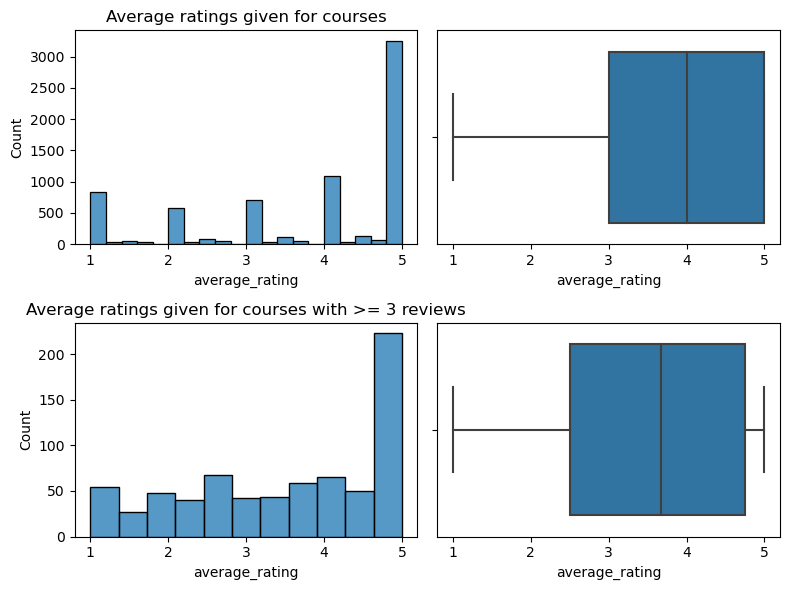

In [54]:
#Average rating plots

#Most students are given classes ratings of close to a 5/5
#Average of average rating is 4, average goes down as courses have more reviews written for it

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(8,6))
numReviews = 3

sns.histplot(data = df, x='average_rating', ax = axes[0][0]).set_title("Average ratings given for courses")
sns.boxplot(data = df, x='average_rating', ax = axes[0][1])

sns.histplot(data = df[df['num_reviews'] >= numReviews], x='average_rating', ax = axes[1][0]).set_title("Average ratings given for courses with >= " + str(numReviews) + " reviews")
sns.boxplot(data = df[df['num_reviews'] >= numReviews], x='average_rating', ax = axes[1][1])

fig.tight_layout()

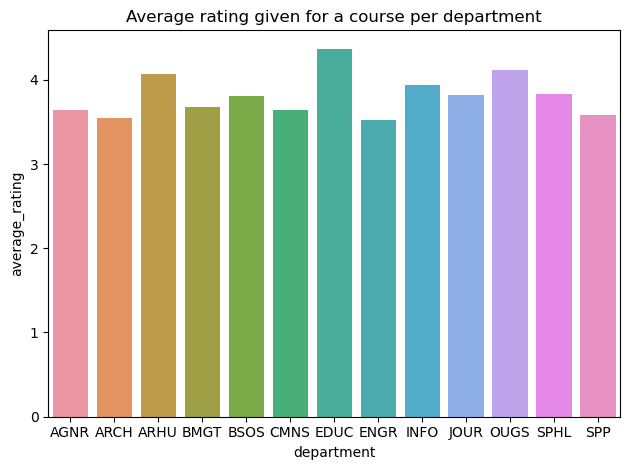

In [139]:
#Average rating given in each department

s = sns.barplot(data = df.groupby('department')['average_rating'].mean().reset_index(), x = 'department', y='average_rating')
s.set(title="Average rating given for a course per department")
plt.tight_layout()

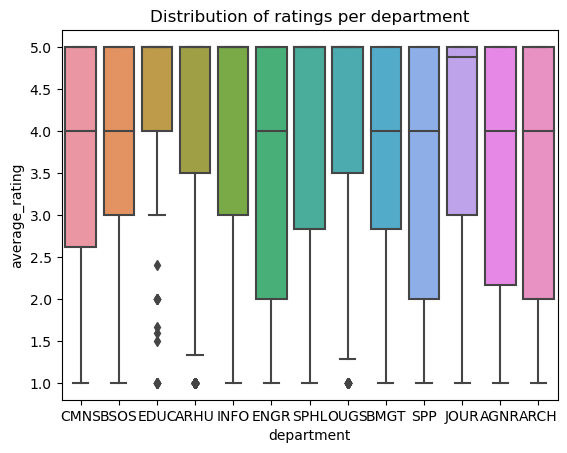

In [140]:
#Distribution of ratings per department

s = sns.boxplot(data=df, x = 'department', y='average_rating')
s.set(title="Distribution of ratings per department")
fig.tight_layout()

In [28]:
#Find Top 10 most taught courses (non UG office)

df_nonug = df[df['department'] != 'Office of Undergraduate Studies']
df_nonug.groupby('course')['name'].nunique().sort_values(ascending=False).head(30)

course
ENGL101     72
ENGL393     47
ENGL394     39
ENGL101S    39
COMM107     37
ENGL391     36
MATH401     31
MATH410     30
ENES100     30
MATH406     29
MATH141     28
ENES100A    27
MATH140     26
STAT410     26
MATH120     24
MATH246     23
ENGL101H    22
MATH241     22
ENGL301     21
MATH461     20
MATH241H    19
CHEM131     19
MATH141H    19
MATH405     18
BMGT495     17
MATH411     17
STAT400     17
MATH310     16
PHYS270     16
INAG110     16
Name: name, dtype: int64

In [45]:
print(len(df_nonug))
print(len(df_nonug[df_nonug['num_reviews'] >= 5]))
print(len(df_nonug[df_nonug['num_reviews'] >= 2]))
print(len(df_nonug[df_nonug['num_reviews'] >= 2]))
print(len(df_nonug[df_nonug['num_reviews'] >= 2]))

39789
206
1677


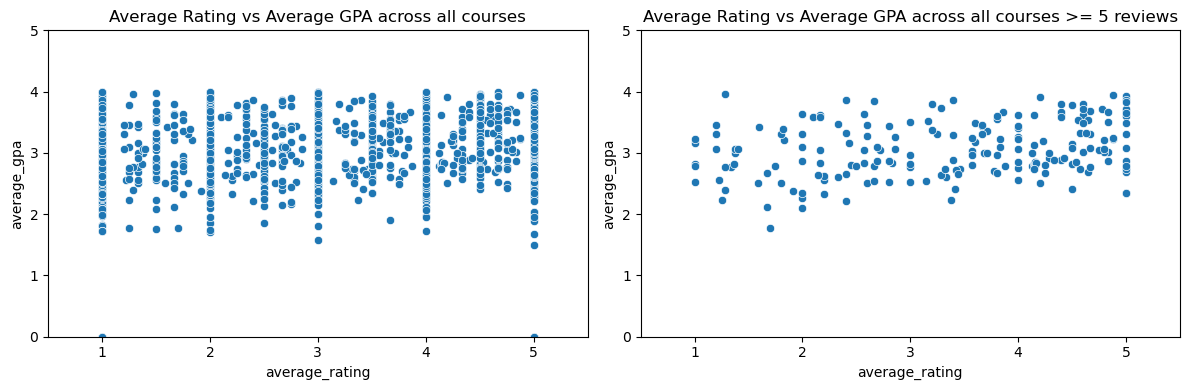

In [125]:
#General average rating vs average gpa for courses - 0 or more vs 5 or more reviews

fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

s1 = sns.scatterplot(data=df, x = 'average_rating', y='average_gpa', ax=ax[0])
s1.set(xlim=(0.5,5.5), ylim=(0,5), title="Average Rating vs Average GPA across all courses")

s2 = sns.scatterplot(data=df[df['num_reviews'] >= 5], x = 'average_rating', y='average_gpa', ax = ax[1])
s2.set(xlim=(0.5,5.5), ylim=(0,5), title="Average Rating vs Average GPA across all courses >= 5 reviews")

fig.tight_layout()

#By requiring that a course have 5 or more reviews written for it, you're removing most whole number ratings, because it's likely that 
#only 1 or 2 reviews were written for a course with a whole number average rating. The more reviews a course has, the less likely its
#average rating is a whole number.

#A linear relationship between average rating and GPA becomes visible

In [180]:
df.dtypes

name                              object
course                            object
department                        object
sem                               object
year                               int64
average_rating                    object
num_reviews                       object
average_gpa                       object
num_students                      object
real_name(s)                      object
years_taught                      object
teaching_duration                  int64
teaching_duration_as_of_course    object
salaries                          object
salary                             int64
departments                       object
_merge                            object
semester                          object
dtype: object

-0.03997469127924259
-0.07849915469699784


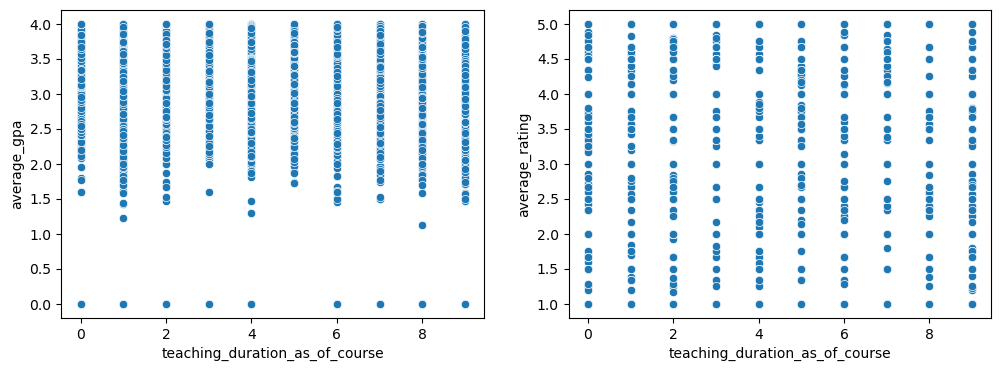

In [188]:
#Scatterplot of teaching duration vs average course rating

fig, axes = plt.subplots(ncols = 2, figsize=(12,4))

s1 = sns.scatterplot(data = df, x = 'teaching_duration_as_of_course', y = 'average_gpa', ax=axes[0])
s2 = sns.scatterplot(data = df, x = 'teaching_duration_as_of_course', y = 'average_rating', ax=axes[1])

df_test = df[(df['average_rating'].notna()) & (df['average_gpa'].notna())].copy()
df_test['average_rating'] = df_test['average_rating'].astype(float)
df_test['average_gpa'] = df_test['average_gpa'].astype(float)

print(df_test['teaching_duration_as_of_course'].corr(df_test['average_rating']))
print(df_test['teaching_duration_as_of_course'].corr(df_test['average_gpa']))

<AxesSubplot: >

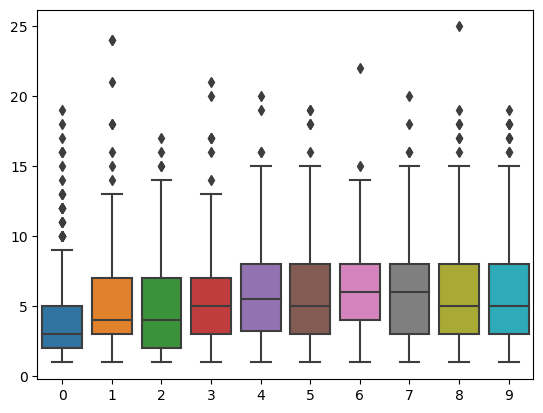

In [208]:
#Number of courses taught by professors with different years of teaching experience

numCoursesTaught = {}

for years_taught in sorted(df['teaching_duration_as_of_course'].unique()):
    df_years_taught = df[(df['teaching_duration_as_of_course'] == years_taught) & (df['average_gpa'].notna())]
    numCoursesTaught[years_taught] = df_years_taught.groupby('name')['course'].nunique()
    

df_numCoursesTaught = pd.DataFrame.from_dict(numCoursesTaught)
sns.boxplot(data=df_numCoursesTaught)

In [212]:
#Relationship between number of courses taught by professors and average gpa and average rating
#this would be across all the years of data we have; might want to differentiate by year/department

df_num_courses_taught = df.groupby('name')['course'].nunique().copy().to_frame().reset_index()
df_num_courses_taught['average_rating'] = df_num_courses_taught['name'].apply(lambda x: df[df['name'] == x]['average_rating'].mean())
df_num_courses_taught['average_gpa'] = df_num_courses_taught['name'].apply(lambda x: df[df['name'] == x]['average_gpa'].mean())


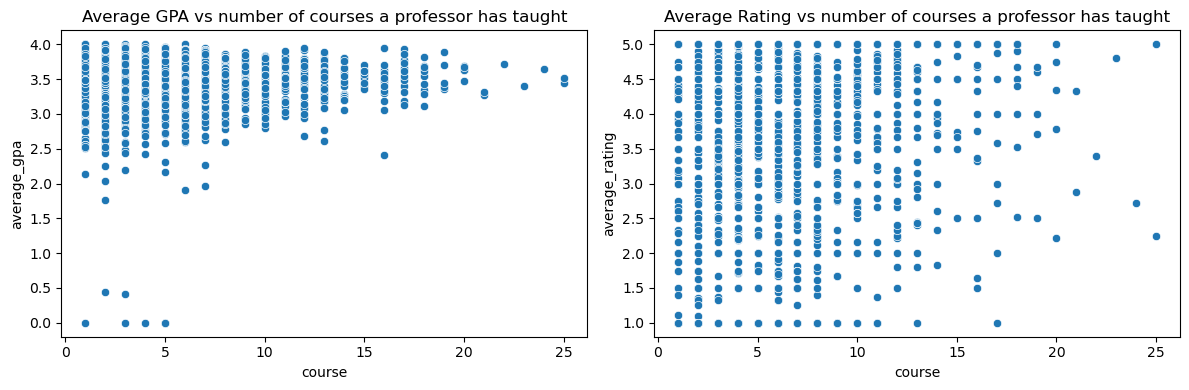

In [216]:
fig, axes = plt.subplots(ncols = 2, figsize=(12,4))

s1 = sns.scatterplot(data = df_num_courses_taught, x = 'course', y='average_gpa', ax=axes[0])
s2 = sns.scatterplot(data = df_num_courses_taught, x = 'course', y='average_rating', ax=axes[1])

s1.set(title='Average GPA vs number of courses a professor has taught')
s2.set(title='Average Rating vs number of courses a professor has taught')

fig.tight_layout()



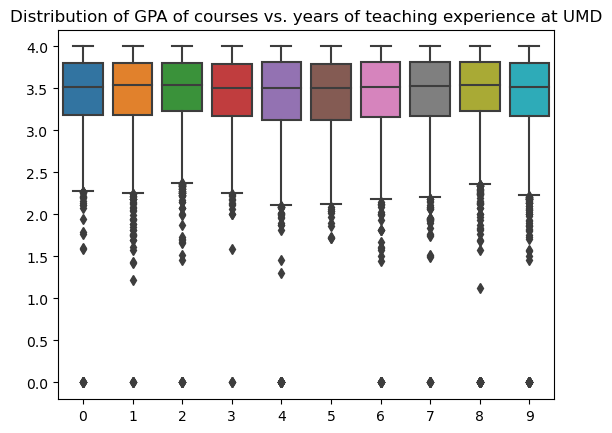

In [110]:
#GPA of courses taught by professors with different years of teaching experience
fig, ax = plt.subplots()
gpa = {}
median_gpas = []

for years_taught in sorted(df['teaching_duration_as_of_course'].unique()):
    df_years_taught = df[(df['teaching_duration_as_of_course'] == years_taught) & (df['average_gpa'].notna())]
    gpa[years_taught] = df_years_taught['average_gpa']
    median_gpas.append(df_years_taught['average_gpa'].median())
    

df_gpa = pd.DataFrame.from_dict(gpa)
s = sns.boxplot(data=df_gpa)
s.set(title="Distribution of GPA of courses vs. years of teaching experience at UMD")
#sns.lineplot(x=np.arange(0,10), y=median_gpas, c='red', linewidth=3)

plt.show()


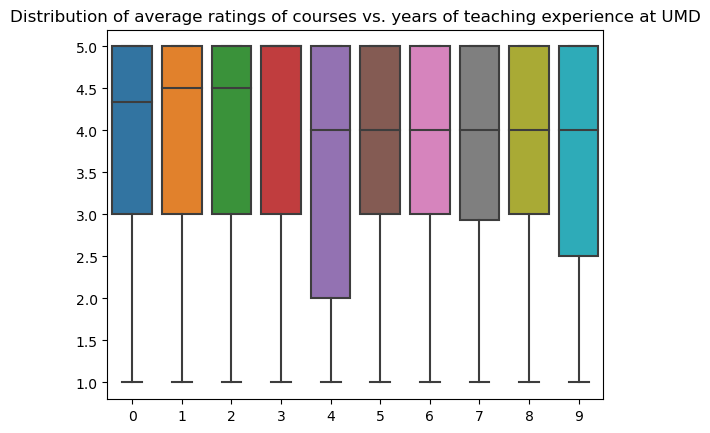

In [112]:
#Average rating of courses taught by professors with different years of teaching experience
fig, ax = plt.subplots()
rating = {}

for years_taught in sorted(df['teaching_duration_as_of_course'].unique()):
    df_years_taught = df[(df['teaching_duration_as_of_course'] == years_taught) & (df['num_students'].notna())]
    rating[years_taught] = df_years_taught['average_rating']    

df_ratings = pd.DataFrame.from_dict(rating)
s = sns.boxplot(data=df_ratings)
s.set(title="Distribution of average ratings of courses vs. years of teaching experience at UMD")
#sns.lineplot(x=np.arange(0,10), y=median_gpas, c='red', linewidth=3)

plt.show()

[Text(0.5, 1.0, 'Average rating of courses vs teaching experience of professors')]

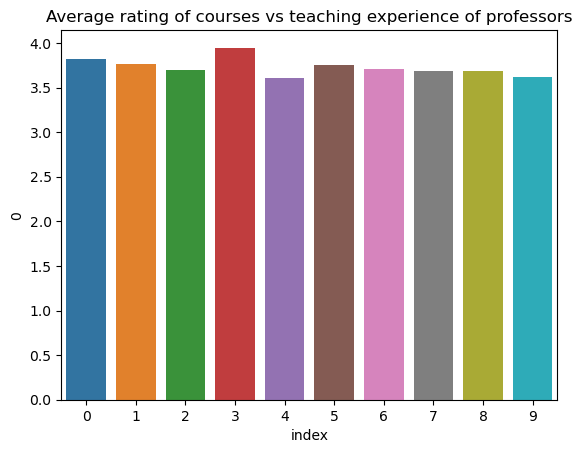

In [118]:
#Average rating of courses taught by professors with different years of teaching experience

fig, ax = plt.subplots()
average_rating = {}

for years_taught in sorted(df['teaching_duration_as_of_course'].unique()):
    df_years_taught = df[(df['teaching_duration_as_of_course'] == years_taught) & (df['average_gpa'].notna())]
    average_rating[years_taught] = df_years_taught['average_rating'].mean()
    

df_rating = pd.DataFrame.from_dict(average_rating, orient='index').reset_index()
s = sns.barplot(data = df_rating, x = 'index', y=0)
s.set(title="Average rating of courses vs teaching experience of professors")

<AxesSubplot: >

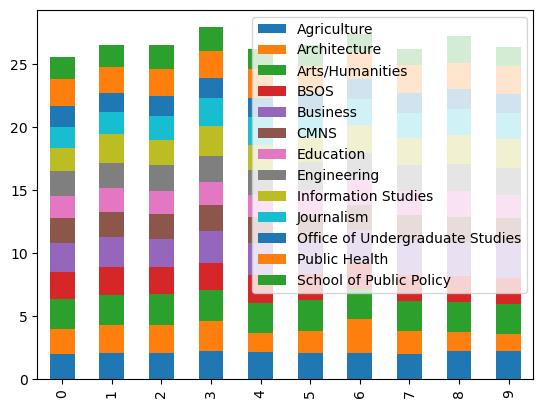

In [437]:
#Average number of courses taught by professors with different years of teaching experience, differentiated by department

avg_courses_by_dept = {}

for dep in sorted(df['department'].unique()):
    df_dep = df[(df['department'] == dep) & (df['average_gpa'].notna())]
    for years_taught in sorted(df_dep['teaching_duration_as_of_course'].unique()):
        df_years_taught = df_dep[(df_dep['teaching_duration_as_of_course'] == years_taught)]
        if dep not in avg_courses_by_dept:
            avg_courses_by_dept[dep] = [df_years_taught.groupby('name')['course'].nunique().mean()]
        else:
            avg_courses_by_dept[dep].append(df_years_taught.groupby('name')['course'].nunique().mean())
    
df_avg_courses_by_dept = pd.DataFrame.from_dict(avg_courses_by_dept)
df_avg_courses_by_dept.plot(kind='bar', stacked=True)

In [159]:
df.head()

,name,course,department,sem,year,average_rating,num_reviews,average_gpa,num_students,real_name(s),years_taught,teaching_duration,teaching_duration_as_of_course,salaries,salary,departments,_merge,semester
0,A SHARMA,ASTR300,CMNS,fall,2019,1.0,1.0,NaN,0,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,fall 2019
1,A SHARMA,ASTR300,CMNS,spring,2019,1.5,2.0,2.85,57,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,spring 2019
2,A SHARMA,ASTR300,CMNS,fall,2020,2.0,1.0,NaN,0,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,fall 2020
3,A SHARMA,ASTR300,CMNS,winter,2021,3.0,1.0,NaN,0,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,winter 2021
4,A SHARMA,ASTR300,CMNS,fall,2016,NaN,NaN,2.92,51,"Sharma, A Surjalal","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...",9,5,"[68417.04, 146412.46, 76537.12, 76537.12, 7768...",77685,"['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,fall 2016


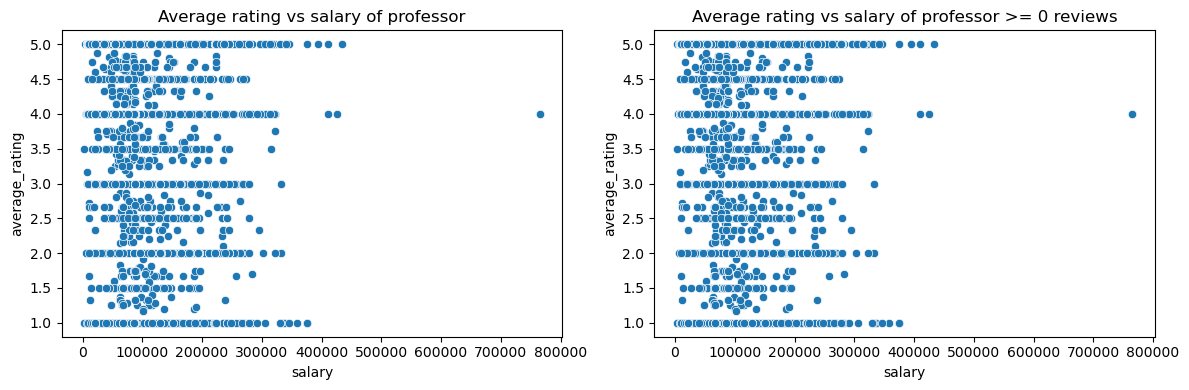

In [107]:
#Relationship between salary and average rating

fig, axes = plt.subplots(ncols = 2, figsize=(12,4))

numReviews = 0

sns.scatterplot(data=df[df['num_reviews'] >= 0], x='salary', y='average_rating', ax = axes[0]).set_title("Average rating vs salary of professor")
sns.scatterplot(data=df[df['num_reviews'] >= numReviews], x='salary', y='average_rating', ax = axes[1]).set_title("Average rating vs salary of professor >= " + str(numReviews) + " reviews")

fig.tight_layout()

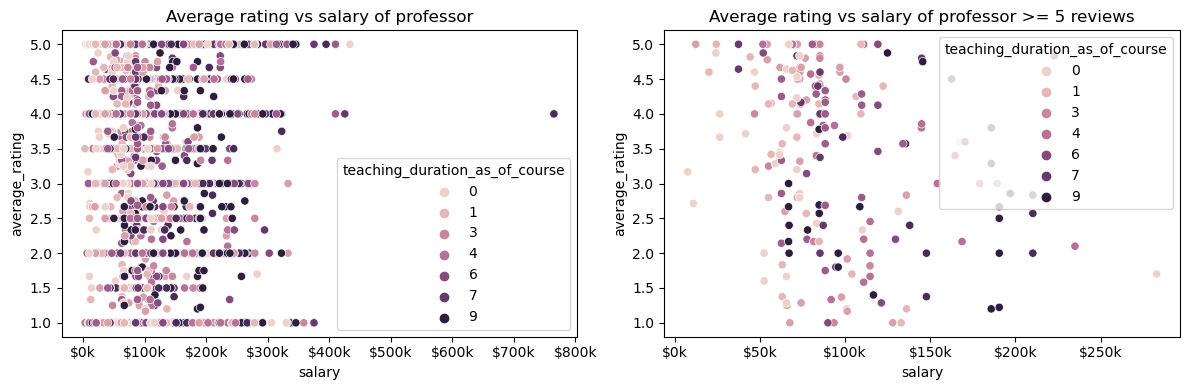

In [157]:
#Relationship between salary and average rating with hue of teaching_duration_as_of_course 
#Professors with a lower teaching experience at UMD tend to have a lower salary, but no correlation
#between 

fig, axes = plt.subplots(ncols = 2, figsize=(12,4))

numReviews = 5

sns.scatterplot(data=df[df['num_reviews'] >= 0], x='salary', y='average_rating', hue='teaching_duration_as_of_course', ax = axes[0]).set_title("Average rating vs salary of professor")
sns.scatterplot(data=df[df['num_reviews'] >= numReviews], x='salary', y='average_rating', hue='teaching_duration_as_of_course', ax = axes[1]).set_title("Average rating vs salary of professor >= " + str(numReviews) + " reviews")

axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

fig.tight_layout()

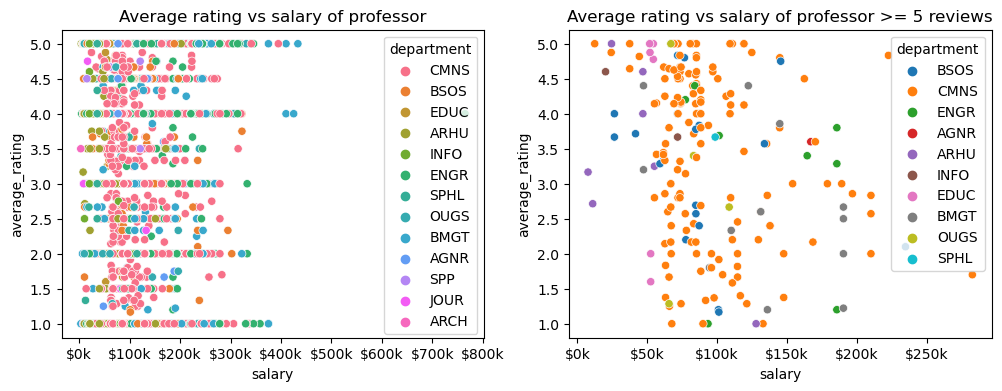

In [158]:
#Relationship between salary and average rating with hue of department
#More dots of CMNS because more reviews for courses in CMNS were written

fig, axes = plt.subplots(ncols = 2, figsize=(12,4))

numReviews = 5

d1 = sns.scatterplot(data=df[df['num_reviews'] >= 0], x='salary', y='average_rating', hue='department', ax = axes[0]).set_title("Average rating vs salary of professor")
d2 = sns.scatterplot(data=df[df['num_reviews'] >= numReviews], x='salary', y='average_rating', hue='department', ax = axes[1]).set_title("Average rating vs salary of professor >= " + str(numReviews) + " reviews")

axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))



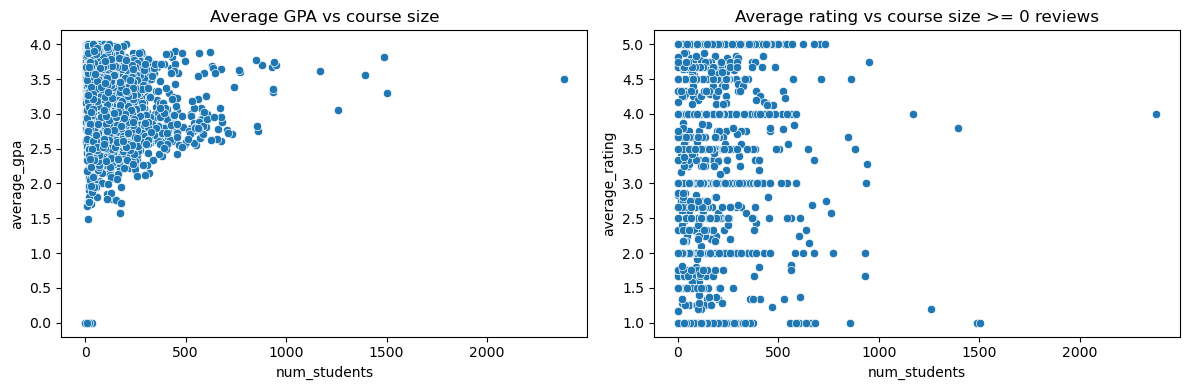

In [193]:
#Relationship between number of students in a course vs average GPA and average rating
#The higher the course size, the more likely that average GPA will be higher (according to left plot)

fig, axes = plt.subplots(ncols = 2, figsize=(12,4))
numReviews = 0

d1 = sns.scatterplot(data=df[df['num_reviews'] >= 0], x='num_students', y='average_gpa', ax = axes[0]).set_title("Average GPA vs course size")
d2 = sns.scatterplot(data=df[df['num_reviews'] >= numReviews], x='num_students', y='average_rating', ax = axes[1]).set_title("Average rating vs course size >= " + str(numReviews) + " reviews")

fig.tight_layout()

<AxesSubplot: xlabel='salary', ylabel='average_gpa'>

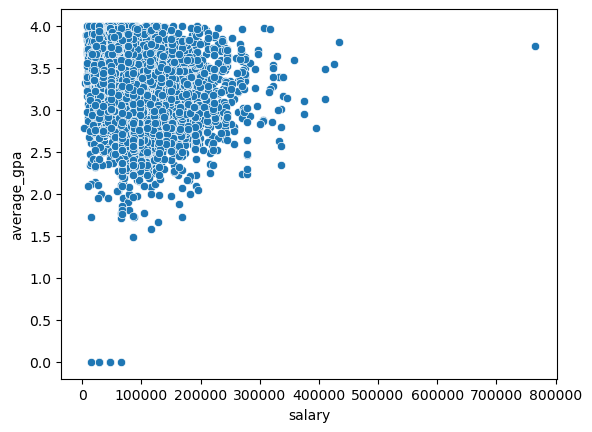

In [95]:
#Relationship between salary and average GPA

#fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(8,6))

numReviews = 0
fig, ax = plt.subplots()

sns.scatterplot(data=df[(df['num_reviews'] >= numReviews)], x='salary', y='average_gpa', ax = ax)

IndexError: list index out of range

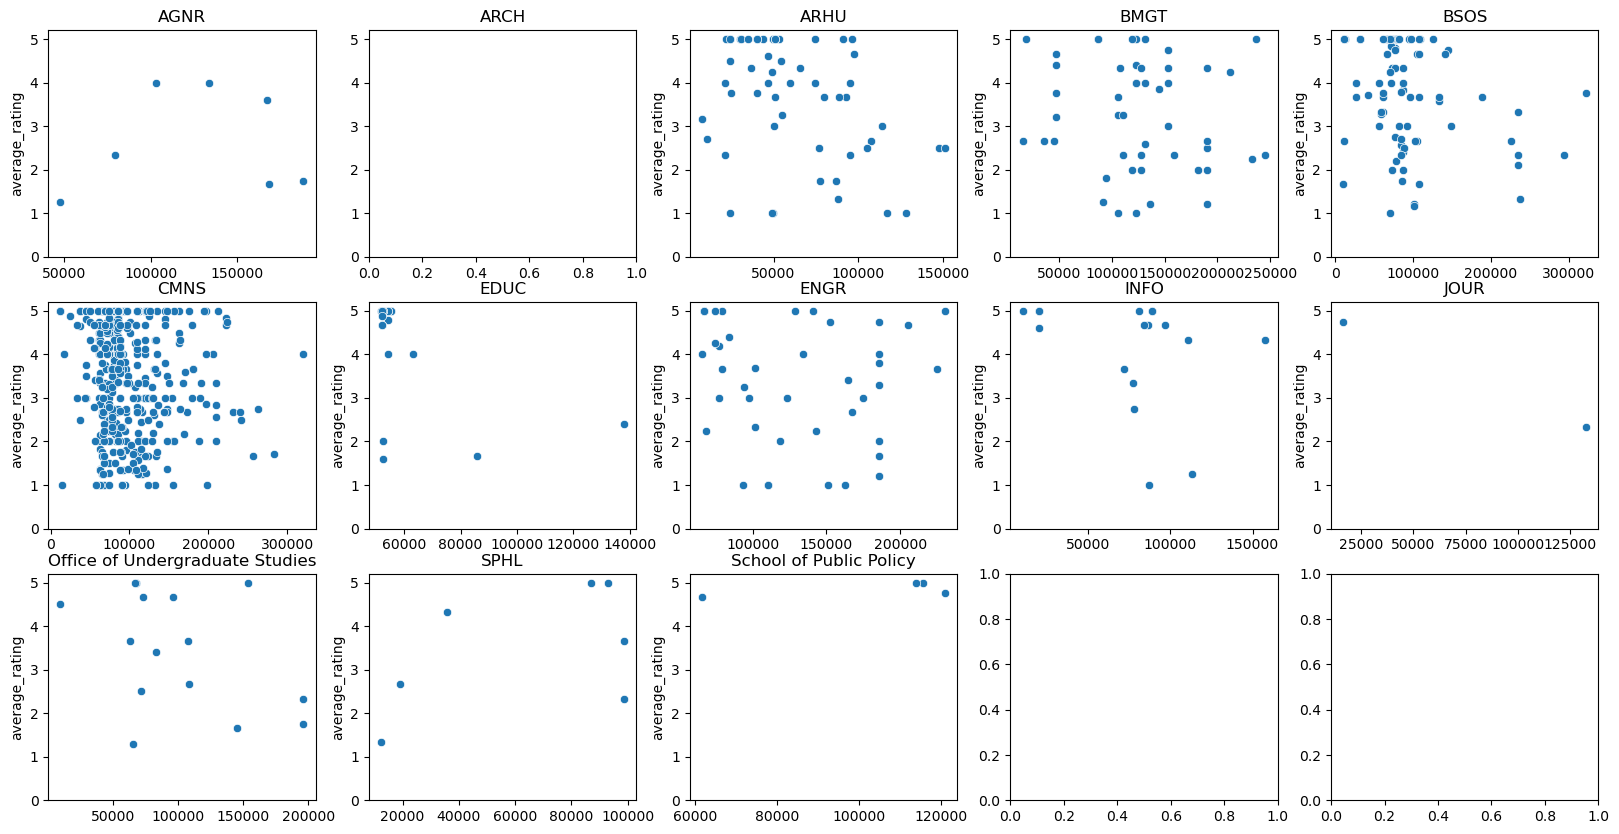

In [100]:
#Scatterplot showing relationship between salary and average rating, differentiated by department

fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize=(20,10))

departments = sorted(df['department'].unique())
depNum = 0
numReviews = 3
for i in range(3):
    for j in range(5):
        df_dep = df[(df['department'] == departments[depNum]) & (df['num_reviews'] >= numReviews)]
        s = sns.scatterplot(data=df_dep, x = 'salary', y='average_rating', ax = axes[i][j])
        s.set(ylim=(0,5.2), title = departments[depNum], xlabel=None)
        depNum+=1
        
fig.tight_layout()
plt.show()

In [ ]:
#Pairplot showing relationship between years_taught_upto_course and average rating, differentiated by department

In [ ]:
#Maybe analysis of COVID (did ratings, num_students, GPA, salary, drop during COVID?)

In [ ]:
#Continue with other variable pairings

<AxesSubplot: xlabel='teaching_duration_as_of_course', ylabel='salary'>

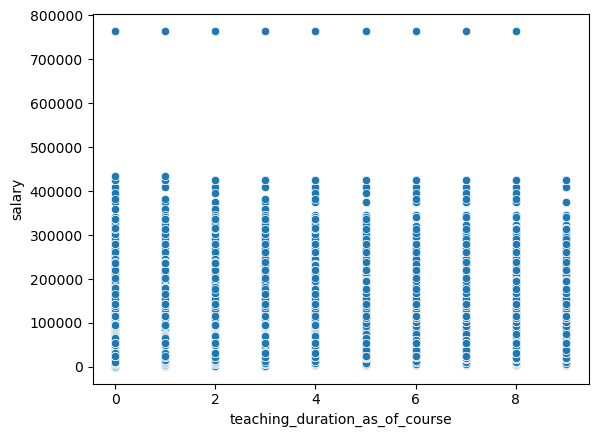

In [462]:
#Scatterplot of teaching duration vs salary

sns.scatterplot(data=df, x='teaching_duration_as_of_course', y='salary')

In [435]:
df_avg_courses_by_dept

,0,1,2,3,4,5,6,7,8,9
Agriculture,2.013514,2.108108,2.121212,2.213115,2.196721,2.129630,2.097561,2.051282,2.270270,2.216216
Architecture,1.954545,2.235294,2.222222,2.437500,1.500000,1.700000,2.714286,1.800000,1.500000,1.400000
Arts/Humanities,2.422018,2.339056,2.412301,2.415049,2.373711,2.427326,2.333333,2.385455,2.371308,2.390000
BSOS,2.126354,2.194332,2.176724,2.158654,2.219251,2.122807,2.139241,2.046667,2.083333,2.016529
Business,2.267677,2.416185,2.208589,2.564935,2.492958,2.537190,2.585586,2.736842,2.666667,2.815385
CMNS,1.980603,1.974596,2.000000,2.016529,2.085799,2.110749,1.979021,2.003774,1.991597,1.932432
Education,1.747126,1.897059,1.793651,1.812500,1.722222,1.979167,1.921053,1.918919,2.064516,1.833333
Engineering,2.015444,2.028926,2.038136,2.106667,2.050926,2.193878,2.164021,2.091954,2.091463,2.136691
Information Studies,1.836066,2.250000,1.976190,2.352941,1.913043,2.000000,2.238095,2.105263,2.312500,2.333333
Journalism,1.666667,1.763158,1.970588,2.214286,2.259259,1.960000,2.095238,2.000000,2.125000,2.071429


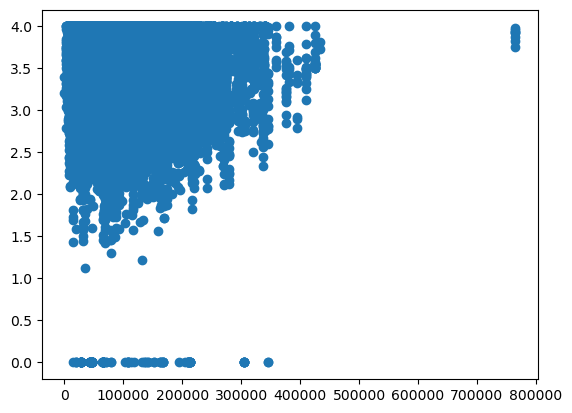

In [43]:
plt.scatter(df_test['salary'], df_test['average_gpa'])